# Setup & Import libraries
---

In [1]:
import os
os.chdir("../")
%ls

data/  kaggle.json  notebooks/  reports/


In [89]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2, ResNet50
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa 
from sklearn.metrics import confusion_matrix, classification_report


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tf.random.set_seed(42)

# Load Dataset
---

In [4]:
def load_dataset(directory: str):
    data = {
        "mapping": ["Accipitridae", "Cathartidae", "Falconidae", "Pandionidae", "Strigidae", "Tytonidae"],
        "img_path": [],
        "target": [],
    }
    target_distributions = {}
    family = None
    for root, dirs, files in os.walk(directory, topdown=False):
        if (len(files) > 0):
            if (family is None or family !=  root.split('/')[2]):
                family = root.split('/')[2]
            if (family in target_distributions.keys()):
                target_distributions[family] += len(files)
            else:
                target_distributions[family] = len(files)
            
            for f in files:
                img_path = os.path.join(root, f)
                data["img_path"].append(img_path)
                data["target"].append(data["mapping"].index(family))
    return data, target_distributions


In [5]:
data, target_distributions = load_dataset("data/birds")

# Exploratory Data Analysis - EDA
---

In [6]:
print(f'Number of images: {len(data["img_path"])}')

Number of images: 42474


**Plot Classes Distribution**

In [7]:
def plot_class_distribution(figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title("Amount of Prey Birds Split for Labels")
    sns.barplot(data=df, x="classes", y="amount")
    plt.show()

In [8]:
df = pd.DataFrame({"classes": list(target_distributions.keys()), "amount": list(target_distributions.values())})
df

,classes,amount
0,Accipitridae,14783
1,Strigidae,12775
2,Tytonidae,1120
3,Pandionidae,1260
4,Cathartidae,5726
5,Falconidae,6810


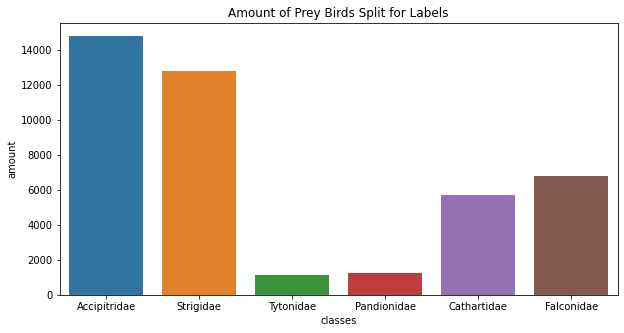

In [9]:
plot_class_distribution() # we have a imbalanced dataset

# Split Train/Validation/Test Set (70/10/30)
---

In [10]:
train_path, test_path, train_target, test_target = train_test_split(data["img_path"], data["target"], random_state=42, test_size=0.3)
train_path, val_path, train_target, val_target = train_test_split(train_path, train_target, random_state=42, test_size=0.14)
print("Amount of samples in Train/Val/Test set")
print(f"Train: {len(train_path)}, Validation: {len(val_path)}, Test: {len(test_path)}")

Amount of samples in Train/Val/Test set
Train: 25568, Validation: 4163, Test: 12743


In [39]:
def read_image(image_path, img_size=300):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=[img_size, img_size])
    image = image / 127.5 - 1
    return image



class DataGenerator(keras.utils.Sequence):
    def __init__(self, img_path, targets, batch_size=32, dim=(300, 300), n_channels=3,
                 n_classes=6, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.targets = targets
        self.img_path = img_path
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_path) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        
        list_img_path_temp = [self.img_path[k] for k in indexes]
        list_target_temp = [self.targets[k] for k in indexes]
        
        # Generate data
        X, y = self.__data_generation(list_img_path_temp, list_target_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.img_path))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_img_path_temp, list_target_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, (img_path, target) in enumerate(zip(list_img_path_temp, list_target_temp)):
            # Store sample
            img = read_image(img_path)
            X[i,] = img

            # Store class
            y[i] = int(target)
        # print(X.shape, y.shape)
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [49]:
# Parameters
params = {'dim': (300, 300),
          'batch_size': 32,
          'n_classes': 6,
          'n_channels': 3,
          'shuffle': True
}
params_test = {'dim': (300, 300),
          'batch_size': 32,
          'n_classes': 6,
          'n_channels': 3,
          'shuffle': False
}


# Generators
training_generator = DataGenerator(train_path, train_target, **params)
validation_generator = DataGenerator(val_path, val_target, **params)
test_generator = DataGenerator(test_path, test_target, **params_test)

# Transfer Learning Approach Using MobileNet
---

In [91]:
def get_model(name="mobilenet"):
    input = keras.Input(shape=shape)
    if (name == "mobilenet"):
        model = MobileNetV2(include_top=True, input_tensor=input, weights="imagenet")
        class1 = keras.layers.Dense(512, activation='relu')(model.layers[-2].output)
    elif (name == "resnet50"):
        model = ResNet50(include_top=True, input_tensor=input, weights="imagenet")
        class1 = keras.layers.Dense(512, activation="relu")(model.layers[-2].output)
        
    output = keras.layers.Dense(6, activation='softmax')(class1)
    model = keras.models.Model(inputs=model.inputs, outputs=output)
    model.summary()
    return model

In [92]:
shape = (300, 300, 3)
model = get_model()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [93]:
lr = 5e-4
optimizer = keras.optimizers.Adam(learning_rate=lr)
metrics = [
    keras.metrics.CategoricalAccuracy(name="accuracy"),
    tfa.metrics.F1Score(36,'micro' or 'macro', name="f1_score"),
]
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=metrics)

In [94]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_f1_score", mode="max", patience=10),
    keras.callbacks.ReduceLROnPlateau(monitor="val_f1_score", patience=3, mode="max"),
    keras.callbacks.ModelCheckpoint("reports/mobilenet_v2/model_{epoch}.h5", monitor='val_f1_score', mode="max", verbose=1, save_best_only=True),
]

In [95]:
history = model.fit(
    training_generator,
    steps_per_epoch=len(train_path) // params["batch_size"],
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(val_path) // params["batch_size"],
    callbacks=callbacks
)

Epoch 1/100
799/799 [==============================] - ETA: 0s - loss: 0.3861 - accuracy: 0.8648 - f1_score: 0.8648
Epoch 1: val_f1_score improved from -inf to 0.58125, saving model to reports/mobilenet_v2/model_1.h5
799/799 [==============================] - 162s 199ms/step - loss: 0.3861 - accuracy: 0.8648 - f1_score: 0.8648 - val_loss: 3.0391 - val_accuracy: 0.5813 - val_f1_score: 0.5813 - lr: 5.0000e-04
Epoch 2/100
799/799 [==============================] - ETA: 0s - loss: 0.2278 - accuracy: 0.9211 - f1_score: 0.9211
Epoch 2: val_f1_score did not improve from 0.58125
799/799 [==============================] - 157s 196ms/step - loss: 0.2278 - accuracy: 0.9211 - f1_score: 0.9211 - val_loss: 8.4180 - val_accuracy: 0.4618 - val_f1_score: 0.4618 - lr: 5.0000e-04
Epoch 3/100
799/799 [==============================] - ETA: 0s - loss: 0.1795 - accuracy: 0.9376 - f1_score: 0.9376
Epoch 3: val_f1_score improved from 0.58125 to 0.63341, saving model to reports/mobilenet_v2/model_3.h5
799/799 

In [98]:
def plot_history(history: dict, n_epochs=26):
    epochs = [i for i in range(n_epochs)]
    fig , ax = plt.subplots(1,3)
    train_f1_score = history["f1_score"]
    train_loss = history["loss"]
    test_f1_score = history["val_f1_score"]
    test_loss = history["val_loss"]
    lr = history["lr"]
    
    fig.set_size_inches(30,12)
    ax[0].plot(epochs, train_loss, label="Training Loss")
    ax[0].plot(epochs, test_loss, label="Validation Loss")
    ax[0].set_title("Training & Validation Loss")
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs, train_f1_score, label="Training F1-score")
    ax[1].plot(epochs, test_f1_score, label="Validation F1-score")
    ax[1].set_title("Training & Validation Accuracy")
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    
    ax[2].plot(epochs, lr, label="Learning Rate")
    ax[2].set_title("Learning Rate Schedule")
    ax[2].legend()
    ax[2].set_xlabel("Epochs")
    plt.show()

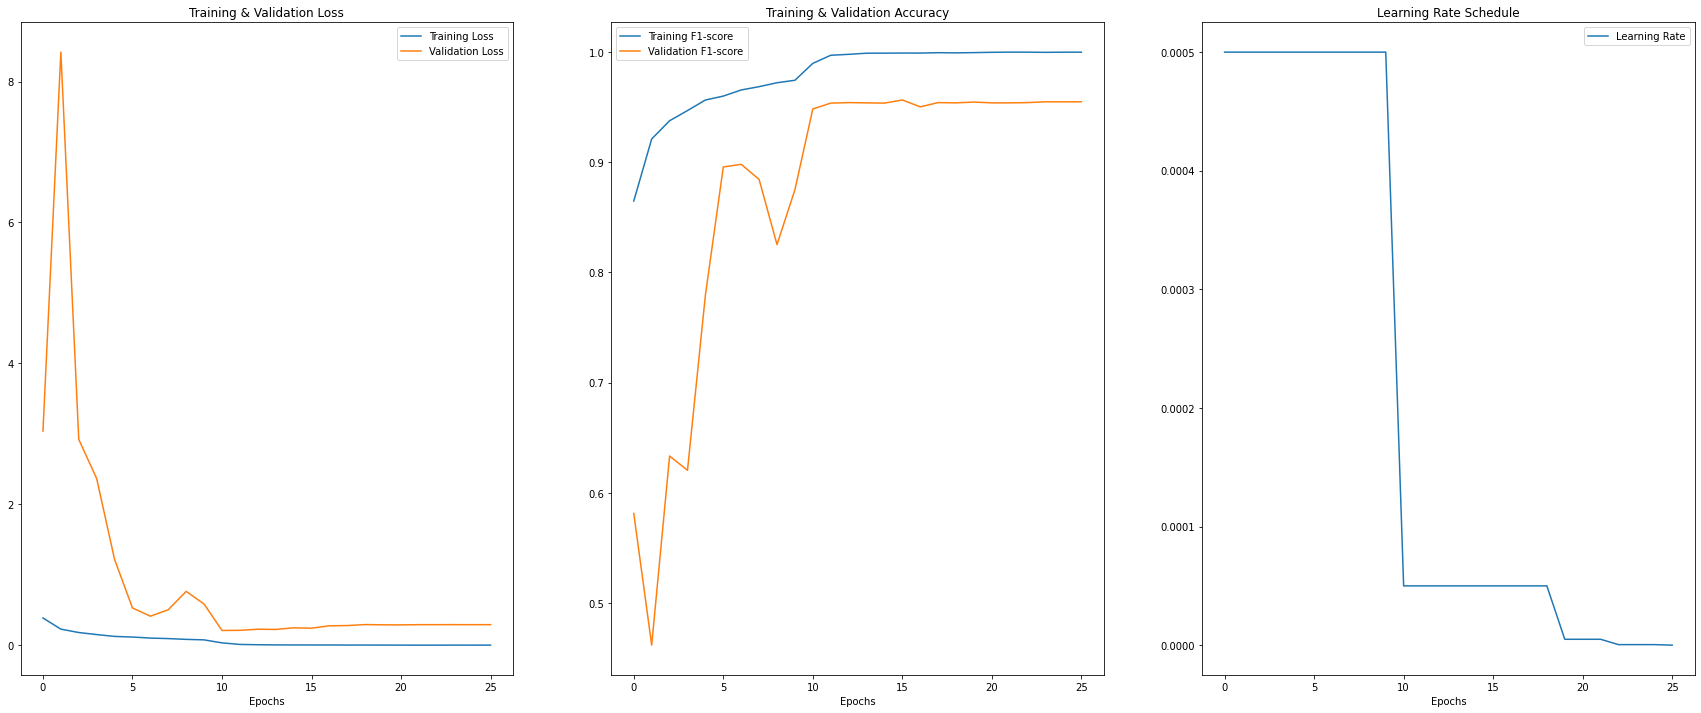

In [99]:
plot_history(history.history)

In [100]:
loss, accuracy, f1_score = model.evaluate(test_generator)
print("Test evaluation")
print(f"loss: {loss}, accuracy: {accuracy}, F1-score: {f1_score}")

398/398 [==============================] - 45s 112ms/step - loss: 0.2552 - accuracy: 0.9572 - f1_score: 0.9572
Test evaluation
loss: 0.25518864393234253, accuracy: 0.9572079181671143, F1-score: 0.9572079181671143


In [101]:
pred = model.predict(test_generator, batch_size=1)

398/398 [==============================] - 45s 113ms/step


In [102]:
y_pred = np.argmax(pred, axis=1)

In [103]:
y_pred.shape

(12736,)

In [104]:
cm = confusion_matrix(test_target, y_pred)
cm

array([[4358,   27,   86,   12,   20,    0],
       [  73, 1593,   12,    6,    2,    1],
       [ 132,   14, 1900,   12,    6,    2],
       [  41,    3,   11,  314,    4,    0],
       [  47,    7,   13,    0, 3692,    3],
       [   1,    2,    0,    0,    8,  334]])

In [106]:
print(classification_report(test_target, y_pred, target_names=data["mapping"]))

              precision    recall  f1-score   support

Accipitridae       0.94      0.97      0.95      4503
 Cathartidae       0.97      0.94      0.96      1687
  Falconidae       0.94      0.92      0.93      2066
 Pandionidae       0.91      0.84      0.88       373
   Strigidae       0.99      0.98      0.99      3762
   Tytonidae       0.98      0.97      0.98       345

    accuracy                           0.96     12736
   macro avg       0.95      0.94      0.95     12736
weighted avg       0.96      0.96      0.96     12736



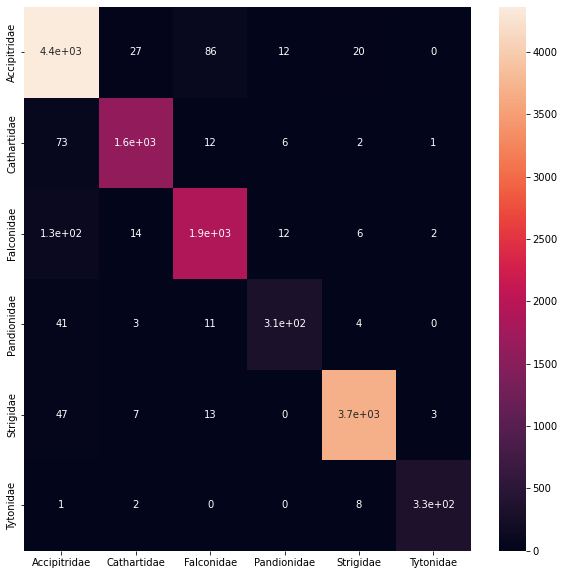

In [107]:
name_labels = data["mapping"]
df_cm = pd.DataFrame(cm, index = [i for i in name_labels],
                  columns = [i for i in name_labels])
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True)
plt.savefig("reports/prey_birds_mobile.png")
plt.show()

In [108]:
df_cm

,Accipitridae,Cathartidae,Falconidae,Pandionidae,Strigidae,Tytonidae
Accipitridae,4358,27,86,12,20,0
Cathartidae,73,1593,12,6,2,1
Falconidae,132,14,1900,12,6,2
Pandionidae,41,3,11,314,4,0
Strigidae,47,7,13,0,3692,3
Tytonidae,1,2,0,0,8,334


# Transfer Learning Approach Using ResNet50
---

In [72]:
shape = (300, 300, 3)
model = get_model(name="resnet50")

102967424/102967424 [==============================] - 2s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

In [77]:
lr = 5e-4
optimizer = keras.optimizers.Adam(learning_rate=lr)
metrics = [
    keras.metrics.CategoricalAccuracy(name="accuracy"),
    tfa.metrics.F1Score(36,'micro' or 'macro', name="f1_score"),
]
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=metrics)

In [78]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_f1_score", mode="max", patience=10),
    keras.callbacks.ReduceLROnPlateau(monitor="val_f1_score", patience=3, mode="max"),
    keras.callbacks.ModelCheckpoint("reports/resnet50/model_{epoch}.h5", monitor='val_f1_score', mode="max", verbose=1, save_best_only=True),
]

In [79]:
history = model.fit(
    training_generator,
    steps_per_epoch=len(train_path) // params["batch_size"],
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(val_path) // params["batch_size"],
    callbacks=callbacks
)

Epoch 1/100
799/799 [==============================] - ETA: 0s - loss: 0.5641 - accuracy: 0.7992 - f1_score: 0.7992
Epoch 1: val_f1_score improved from -inf to 0.72644, saving model to reports/resnet50/model_1.h5
799/799 [==============================] - 225s 276ms/step - loss: 0.5641 - accuracy: 0.7992 - f1_score: 0.7992 - val_loss: 0.7271 - val_accuracy: 0.7264 - val_f1_score: 0.7264 - lr: 5.0000e-04
Epoch 2/100
799/799 [==============================] - ETA: 0s - loss: 0.3247 - accuracy: 0.8829 - f1_score: 0.8829
Epoch 2: val_f1_score improved from 0.72644 to 0.84062, saving model to reports/resnet50/model_2.h5
799/799 [==============================] - 220s 275ms/step - loss: 0.3247 - accuracy: 0.8829 - f1_score: 0.8829 - val_loss: 0.5127 - val_accuracy: 0.8406 - val_f1_score: 0.8406 - lr: 5.0000e-04
Epoch 3/100
799/799 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.9137 - f1_score: 0.9137
Epoch 3: val_f1_score did not improve from 0.84062
799/799 [=======

In [80]:
def plot_history(history: dict, n_epochs=23):
    epochs = [i for i in range(n_epochs)]
    fig , ax = plt.subplots(1,3)
    train_f1_score = history["f1_score"]
    train_loss = history["loss"]
    test_f1_score = history["val_f1_score"]
    test_loss = history["val_loss"]
    lr = history["lr"]
    
    fig.set_size_inches(30,12)
    ax[0].plot(epochs, train_loss, label="Training Loss")
    ax[0].plot(epochs, test_loss, label="Validation Loss")
    ax[0].set_title("Training & Validation Loss")
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs, train_f1_score, label="Training F1-score")
    ax[1].plot(epochs, test_f1_score, label="Validation F1-score")
    ax[1].set_title("Training & Validation Accuracy")
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    
    ax[2].plot(epochs, lr, label="Learning Rate")
    ax[2].set_title("Learning Rate Schedule")
    ax[2].legend()
    ax[2].set_xlabel("Epochs")
    plt.show()

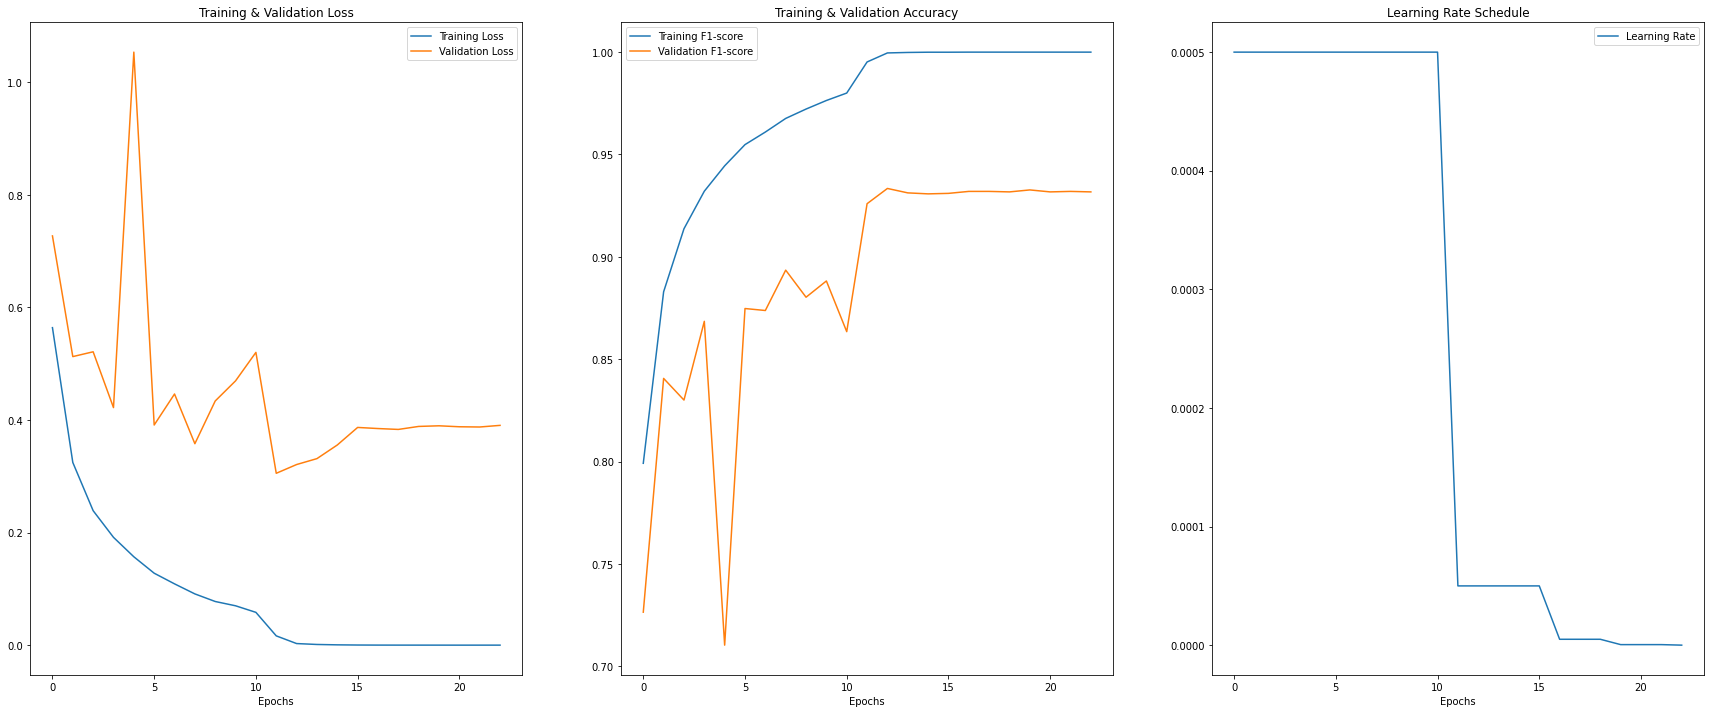

In [81]:
plot_history(history.history)

In [82]:
loss, accuracy, f1_score = model.evaluate(test_generator)
print("Test evaluation")
print(f"loss: {loss}, accuracy: {accuracy}, F1-score: {f1_score}")

398/398 [==============================] - 54s 136ms/step - loss: 0.3698 - accuracy: 0.9353 - f1_score: 0.9353
Test evaluation
loss: 0.36975815892219543, accuracy: 0.9353014826774597, F1-score: 0.9353014826774597


In [83]:
pred = model.predict(test_generator, batch_size=1)

398/398 [==============================] - 55s 137ms/step


In [84]:
y_pred = np.argmax(pred, axis=1)

In [86]:
cm = confusion_matrix(test_target, y_pred)
cm

array([[4322,   50,   91,   12,   28,    0],
       [ 108, 1546,   19,    5,    9,    0],
       [ 254,   27, 1763,   10,   12,    0],
       [  62,    7,   14,  288,    2,    0],
       [  72,    7,    7,    2, 3671,    3],
       [   3,    2,    6,    0,   12,  322]])

In [90]:
print(classification_report(test_target, y_pred, target_names=data["mapping"]))

              precision    recall  f1-score   support

Accipitridae       0.90      0.96      0.93      4503
 Cathartidae       0.94      0.92      0.93      1687
  Falconidae       0.93      0.85      0.89      2066
 Pandionidae       0.91      0.77      0.83       373
   Strigidae       0.98      0.98      0.98      3762
   Tytonidae       0.99      0.93      0.96       345

    accuracy                           0.94     12736
   macro avg       0.94      0.90      0.92     12736
weighted avg       0.94      0.94      0.93     12736



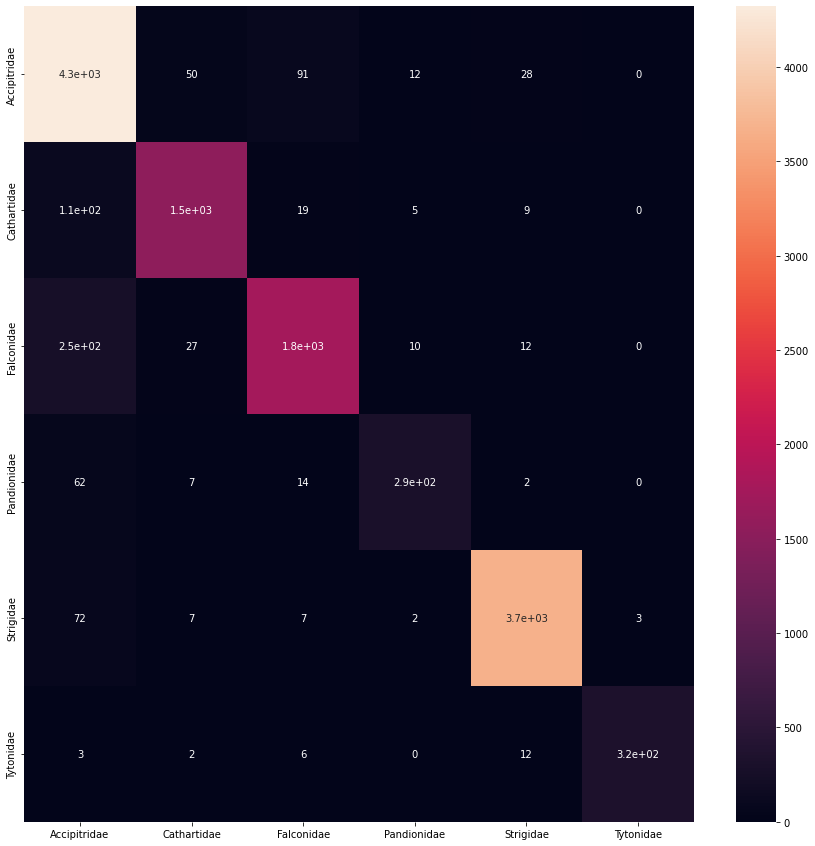

In [87]:
name_labels = data["mapping"]
df_cm = pd.DataFrame(cm, index = [i for i in name_labels],
                  columns = [i for i in name_labels])
plt.figure(figsize = (15,15))
sns.heatmap(df_cm, annot=True)
plt.savefig("reports/prey_birds_resnet.png")

In [88]:
df_cm

,Accipitridae,Cathartidae,Falconidae,Pandionidae,Strigidae,Tytonidae
Accipitridae,4322,50,91,12,28,0
Cathartidae,108,1546,19,5,9,0
Falconidae,254,27,1763,10,12,0
Pandionidae,62,7,14,288,2,0
Strigidae,72,7,7,2,3671,3
Tytonidae,3,2,6,0,12,322
